In [1]:
# -----------------------------------------------------------
# CELL 1: INSTALL (Run First & Restart Kernel)
# -----------------------------------------------------------
!pip install -q "monai" "protobuf==3.20.3" "segmentation-models-pytorch"

print("\n✅ Installation Complete.")
print("⚠️ CRITICAL STEP: Please RESTART THE SESSION now (Kernel -> Restart).")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# -----------------------------------------------------------
# CELL 2: IMPORTS & SETUP
# -----------------------------------------------------------
import os
import glob
import gc
import numpy as np
import matplotlib.pyplot as plt
import cv2
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
import segmentation_models_pytorch as smp

pl.seed_everything(42)
print(f"🔥 Is GPU working? {torch.cuda.is_available()}")
print(f"   GPU Name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")
print("✅ Imports complete. Ready for STANDARD U-NET.")


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

🔥 Is GPU working? True
   GPU Name: Tesla T4
✅ Imports complete. Ready for STANDARD U-NET.


In [3]:
# -----------------------------------------------------------
# CELL 3: DATA LOADING
# -----------------------------------------------------------
import os
import glob
import h5py
import torch
import numpy as np
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader, random_split

# CONFIG
NUM_WORKERS = 2   # Keep 2 for stability in some environments
BATCH_SIZE = 32   # Reduced to 32 for ResNet safety (was 64)

def find_file(keyword):
    # Searches for file in standard Kaggle/local paths
    files = glob.glob(f"/kaggle/input/**/*{keyword}*", recursive=True)
    if not files:
        # Fallback for local testing if not on Kaggle
        files = glob.glob(f"./**/*{keyword}*", recursive=True)
    if not files:
        raise FileNotFoundError(f"Missing {keyword} files")
    files.sort()
    return files[0]

try:
    xpath = find_file("split_train_x")
    ypath = find_file("split_train_mask")
    print(f"✅ Found Images: {os.path.basename(xpath)}")
except FileNotFoundError as e:
    print(f"❌ Error: {e}")
    print("Please ensure your dataset is attached/uploaded.")

class CamelyonSegmentationDataset(Dataset):
    def __init__(self, xpath, ypath, transform=None):
        self.xpath = xpath
        self.ypath = ypath
        self.transform = transform
        
        with h5py.File(self.xpath, 'r') as f:
            self.xkey = list(f.keys())[0]
            self.length = len(f[self.xkey])
        
        with h5py.File(self.ypath, 'r') as f:
            self.ykey = list(f.keys())[0]
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        with h5py.File(self.xpath, 'r') as f:
            image = f[self.xkey][idx][...]
        
        with h5py.File(self.ypath, 'r') as f:
            mask = f[self.ykey][idx][...]
        
        if mask.ndim == 3:
            mask = mask.squeeze(-1)
        
        # Convert to tensor
        image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        mask = torch.from_numpy(mask).unsqueeze(0).float()
        
        # Resize to 224x224 (Standard for ResNet)
        resize = T.Resize((224, 224), antialias=True)
        image = resize(image)
        mask = resize(mask)
        mask = (mask > 0.5).float()
        
        return image, mask

# Initialize full dataset
fulldataset = CamelyonSegmentationDataset(xpath, ypath)
total_len = len(fulldataset)

# Split: 70% train, 15% val, 15% test
train_len = int(0.70 * total_len)
val_len = int(0.15 * total_len)
test_len = total_len - train_len - val_len

print(f"📊 Dataset Split:")
print(f"   Train: {train_len} samples")
print(f"   Val:   {val_len} samples")
print(f"   Test:  {test_len} samples")

# Create splits
train_dataset, val_dataset, test_dataset = random_split(
    fulldataset, 
    [train_len, val_len, test_len]
)

# Create dataloaders
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"✅ Data Loaded | Batch Size: {BATCH_SIZE}")


✅ Found Images: camelyonpatch_level_2_split_train_x-002 (1).h5
📊 Dataset Split:
   Train: 183500 samples
   Val:   39321 samples
   Test:  39323 samples
✅ Data Loaded | Batch Size: 32


Image Batch Shape: torch.Size([32, 3, 224, 224])
Mask Batch Shape:  torch.Size([32, 1, 224, 224])


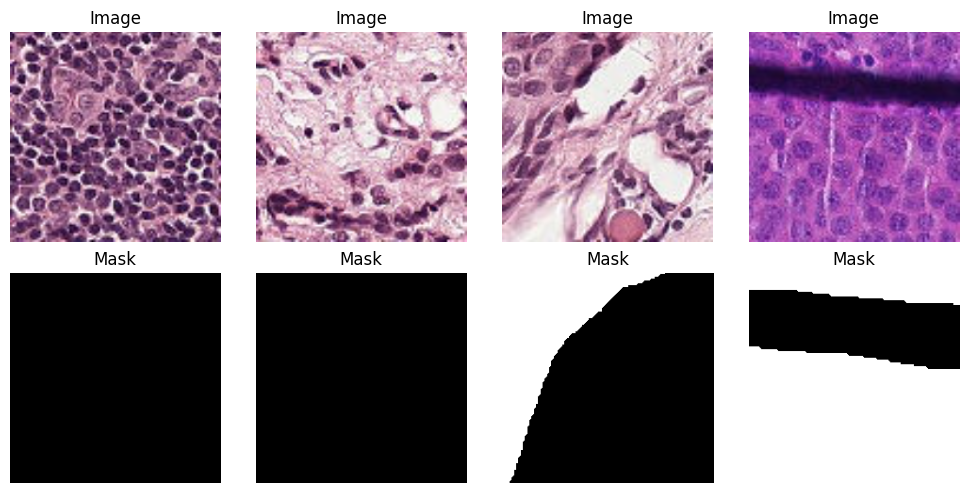

In [4]:
# -----------------------------------------------------------
# CELL 4: VISUALIZE DATA BATCH
# -----------------------------------------------------------
import matplotlib.pyplot as plt

# Get a single batch
data_iter = iter(trainloader)
images, masks = next(data_iter)

print(f"Image Batch Shape: {images.shape}")
print(f"Mask Batch Shape:  {masks.shape}")

plt.figure(figsize=(10, 5))
for i in range(4):
    # Image
    plt.subplot(2, 4, i+1)
    img = images[i].permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title("Image")
    plt.axis('off')
    
    # Mask
    plt.subplot(2, 4, i+5)
    msk = masks[i].squeeze().numpy()
    plt.imshow(msk, cmap='gray')
    plt.title("Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [5]:
# -----------------------------------------------------------
# CELL 5: MODEL DEFINITION (Standard ResNet34 U-Net)
# -----------------------------------------------------------
import pytorch_lightning as pl
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp

class StandardUNet(pl.LightningModule):
    def __init__(self, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()
        
        # U-Net with ResNet34 encoder (Standard powerful U-Net)
        self.model = smp.Unet(
            encoder_name="resnet34",        
            encoder_weights="imagenet",     
            in_channels=3,
            classes=1
        )
        
        # Loss functions
        self.lossfn = smp.losses.DiceLoss(mode='binary', from_logits=True)
        self.bceloss = nn.BCEWithLogitsLoss()
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        dice_loss = self.lossfn(logits, y)
        bce_loss = self.bceloss(logits, y)
        loss = 0.5 * dice_loss + 0.5 * bce_loss
        self.log('train_loss', loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        dice_loss = self.lossfn(logits, y)
        bce_loss = self.bceloss(logits, y)
        loss = 0.5 * dice_loss + 0.5 * bce_loss
        
        preds = torch.sigmoid(logits)
        preds = (preds > 0.5).float()
        intersection = (preds * y).sum()
        union = preds.sum() + y.sum()
        dice_score = (2. * intersection) / (union + 1e-8)
        
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_dice_score', dice_score, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        preds = torch.sigmoid(logits)
        preds = (preds > 0.5).float()
        intersection = (preds * y).sum()
        union = preds.sum() + y.sum()
        dice_score = (2. * intersection) / (union + 1e-8)
        self.log('test_dice_score', dice_score, prog_bar=True)
        return {'test_dice_score': dice_score}
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        # FIXED: Removed 'verbose=True' which causes the TypeError in newer PyTorch
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5
        )
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

print("✅ Model defined: Standard U-Net (ResNet34) - FIXED")

 
 
     


✅ Model defined: Standard U-Net (ResNet34) - FIXED


In [6]:
# -----------------------------------------------------------
# CELL 6: TRAINING LOOP
# -----------------------------------------------------------
import os
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

BASE_DIR = os.getcwd()
CHECKPOINT_DIR = os.path.join(BASE_DIR, 'checkpoints')
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print("🚀 Starting Training (Standard U-Net)...")

# Initialize Model
model = StandardUNet(learning_rate=1e-3)

# Checkpoint Callback
checkpoint_callback = ModelCheckpoint(
    dirpath=CHECKPOINT_DIR, 
    filename='best_standard_unet',
    monitor='val_dice_score',
    mode='max', 
    save_top_k=1, 
    verbose=True
)

# Trainer
trainer = pl.Trainer(
    max_epochs=20,
    limit_train_batches=0.20,  # Train on 20% of data for speed
    limit_val_batches=0.10,   
    accelerator="gpu" if torch.cuda.is_available() else "cpu", 
    devices=1, 
    precision="16-mixed",      # Saves memory
    callbacks=[checkpoint_callback], 
    logger=CSVLogger(save_dir=BASE_DIR, name="logs_standard_unet"),
    default_root_dir=BASE_DIR
)

trainer.fit(model, trainloader, valloader)
print("✅ Training Complete.")


🚀 Starting Training (Standard U-Net)...


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | Unet              | 24.4 M | train
1 | lossfn  | DiceLoss          | 0      | train
2 | bceloss | BCEWithLogitsLoss | 0      | train
------------------------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.745    Total estimated model params size (MB)
190       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 1147: 'val_dice_score' reached 0.79943 (best 0.79943), saving model to '/kaggle/working/checkpoints/best_standard_unet.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 2294: 'val_dice_score' reached 0.83968 (best 0.83968), saving model to '/kaggle/working/checkpoints/best_standard_unet.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 3441: 'val_dice_score' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 4588: 'val_dice_score' reached 0.84091 (best 0.84091), saving model to '/kaggle/working/checkpoints/best_standard_unet.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 5735: 'val_dice_score' reached 0.86236 (best 0.86236), saving model to '/kaggle/working/checkpoints/best_standard_unet.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 6882: 'val_dice_score' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 8029: 'val_dice_score' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 9176: 'val_dice_score' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 10323: 'val_dice_score' reached 0.86915 (best 0.86915), saving model to '/kaggle/working/checkpoints/best_standard_unet.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 11470: 'val_dice_score' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 12617: 'val_dice_score' reached 0.89482 (best 0.89482), saving model to '/kaggle/working/checkpoints/best_standard_unet.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 13764: 'val_dice_score' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 14911: 'val_dice_score' reached 0.89570 (best 0.89570), saving model to '/kaggle/working/checkpoints/best_standard_unet.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 16058: 'val_dice_score' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 17205: 'val_dice_score' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 18352: 'val_dice_score' reached 0.90281 (best 0.90281), saving model to '/kaggle/working/checkpoints/best_standard_unet.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 19499: 'val_dice_score' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 20646: 'val_dice_score' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 21793: 'val_dice_score' reached 0.90715 (best 0.90715), saving model to '/kaggle/working/checkpoints/best_standard_unet.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 22940: 'val_dice_score' was not in top 1
`Trainer.fit` stopped: `max_epochs=20` reached.


✅ Training Complete.


In [7]:
# ----------------------------------------------------------- 
# CELL 7: EVALUATION
# -----------------------------------------------------------
import torch
import glob
import os

# Find best checkpoint
ckpt_folder = os.path.join(os.getcwd(), "checkpoints")
# Specifically look for our NEW model file
checkpoint_files = glob.glob(os.path.join(ckpt_folder, "best_standard_unet*.ckpt"))

if not checkpoint_files:
    raise FileNotFoundError("No Standard U-Net checkpoint found! Did training finish?")

# Get latest if multiple exist
best_model_path = sorted(checkpoint_files)[-1]
print(f"🏆 Loading Best Model: {os.path.basename(best_model_path)}")

# Load Model (Using the NEW class)
best_model = StandardUNet.load_from_checkpoint(best_model_path)
best_model.eval()

# Run Test
trainer.test(best_model, testloader)


🏆 Loading Best Model: best_standard_unet.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_dice_score      │    0.9102550745010376     │
└───────────────────────────┴───────────────────────────┘

[{'test_dice_score': 0.9102550745010376}]

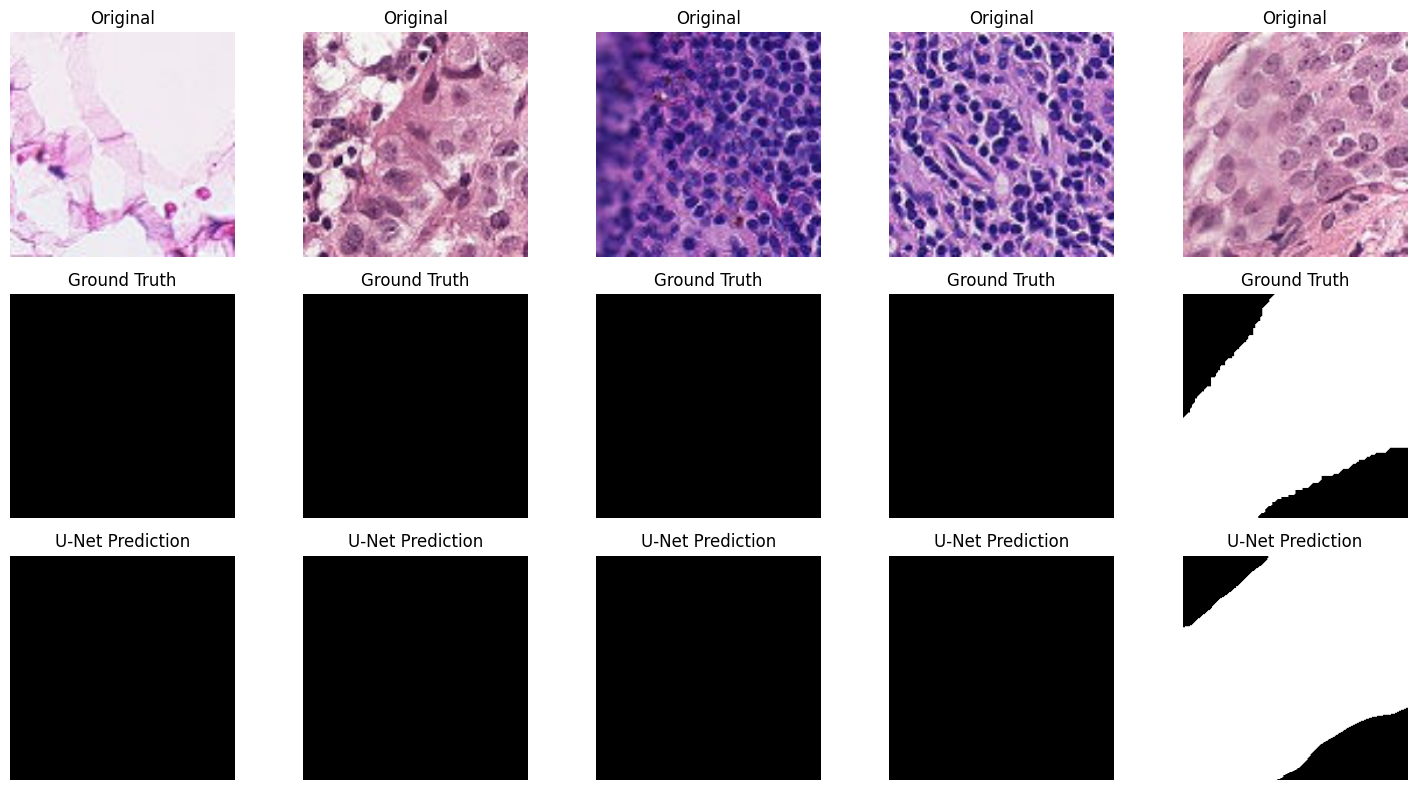

In [8]:
# -----------------------------------------------------------
# CELL 8: VISUALIZATION
# -----------------------------------------------------------
import matplotlib.pyplot as plt
import torch
import random

device = "cuda" if torch.cuda.is_available() else "cpu"
best_model.to(device)
best_model.eval()

# Get a random batch
images, masks = next(iter(testloader))
images = images.to(device)

with torch.no_grad():
    logits = best_model(images)
    preds = torch.sigmoid(logits)
    preds = (preds > 0.5).float()

# Move back to CPU for plotting
images = images.cpu()
preds = preds.cpu()
masks = masks.cpu()

# Plot first 5
plt.figure(figsize=(15, 8))
for i in range(min(5, len(images))):
    # Original Image
    plt.subplot(3, 5, i+1)
    plt.imshow(images[i].permute(1,2,0))
    plt.title("Original")
    plt.axis("off")
    
    # Ground Truth Mask
    plt.subplot(3, 5, i+6)
    plt.imshow(masks[i].squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.axis("off")
    
    # Prediction
    plt.subplot(3, 5, i+11)
    plt.imshow(preds[i].squeeze(), cmap='gray')
    plt.title("U-Net Prediction")
    plt.axis("off")

plt.tight_layout()
plt.show()
